<a href="https://colab.research.google.com/github/pln-fing-udelar/cursos/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis

Facultad de Ingeniería - Universidad de la República - Uruguay

12 de octubre de 2025

En este notebook presentaremos el Análisis de Componentes Principales (PCA), un método no supervisado para encontrar patrones en conjuntos de datos de alta dimensionalidad, y realizar reducción de dimensiones. PCA centra, rota y escala los datos, permitiendo eliminar algunas dimensiones de varianza baja, y de esta forma permitiendo también mejor performance para algunos métodos, así como una visualización exploratoria de los datos.

El documento está basado en las siguientes referencias (y el código está principalmente tomado de la tercera):

[A Beginner’s Guide to Eigenvectors, PCA, Covariance and Entropy](http://deeplearning4j.org/eigenvector)

[A tutorial on PCA](https://www.iro.umontreal.ca/~pift6080/H08/documents/papers/pca_tutorial.pdf)(Lindsay Smiths)

[PCA Step by step in Python](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) (Sebastian Raschka)

Utilizaremos las bibliotecas Numpy y Matplotlib de Python para realizar una implementación de ejemplo.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pln-fing-udelar/cursos/blob/master/tutoriales/PCA.ipynb)

In [19]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
np.set_printoptions(suppress=True,precision=3)
from matplotlib.patches import FancyArrowPatch

Definamos un dataset muy simple, con 6 personas, identificadas por su altura, peso, y la longitud de su dedo anular (?). Cada columna es una instancia con 3 atributos. Definiremos 3 mujeres y 3 hombres como referencia, pero utilizaremos todas las instancias juntas para realizar PCA. Llamaremos a esta matriz $X \in \mathbb{R}^{3 \times m}$ (en nuestro caso, $m$, el número de instancias, es 6).

In [20]:
num_instances=6
X_men=np.array([[1.97,110,5],[1.80,70,4.8],[1.70,90,4.9]]).transpose()
X_women=np.array([[1.65,52,4.7],[1.75,65,4.8],[1.67,58,4.6]]).transpose()

# Por si queremos jugar con más instancias
#num_instances=20
#X_men = np.random.multivariate_normal([1.75,80,4.7], [[0.010,0,0],[0,1,0],[0,0,0.01]],num_instances).T
#X_women = np.random.multivariate_normal([1.60,70,4.7], [[0.010,0,0],[0,1,0],[0,0,0.01]],num_instances).T

X = np.hstack((X_men,X_women))
print (X)

[[  1.97   1.8    1.7    1.65   1.75   1.67]
 [110.    70.    90.    52.    65.    58.  ]
 [  5.     4.8    4.9    4.7    4.8    4.6 ]]


Para comenzar, calcularemos media y varianza de cada una de las columnas.

La media es, por supuesto:

$$ \bar{X} = \frac{\sum_{i=n}^n X_i }{n} $$

Y la varianza mide qué tanto los datos se alejan de la media:

$$ var(X) = \frac{\sum_{i=n}^n (X_i - \bar{X})(X_i - \bar{X}) }{n-1} $$



In [21]:
mean=np.mean(X,axis=1) #Observar que tomamos la media de cada fila, por eso axis=1
std=np.std(X,axis=1)
var=np.var(X,axis=1)

print ("Medias:",mean)
print ("Varianzas:",var)
print ("Desviaciones estándar:",std)

Medias: [ 1.757 74.167  4.8  ]
Varianzas: [  0.012 398.139   0.017]
Desviaciones estándar: [ 0.108 19.953  0.129]


La desviación estándar es simplemente la raíz cuadrada de la varianza (la utlizamos porque es comparable con la media).  Observemos que al tomar cuadrados, las desviaciones positivas y negativas de la media _no_ se cancelan.

Reescalamos los valores. Para esto, restamos la media a cada dimensión (y nuestro conjunto queda centrado en (0,0,0), y dividimos por la desviacion estándar de la muestra). LLamaremos $X_r \in \mathbb{R}^{3 \times m}$ a la matriz obtenida.

In [22]:
MediaOrigen = X.mean(axis=1,keepdims=True)
DesviacionEstandar = X.std(axis=1,keepdims=True)
X_r = (X - MediaOrigen)/DesviacionEstandar

print (X_r)

[[ 1.982  0.403 -0.526 -0.991 -0.062 -0.805]
 [ 1.796 -0.209  0.794 -1.111 -0.459 -0.81 ]
 [ 1.549 -0.     0.775 -0.775 -0.    -1.549]]


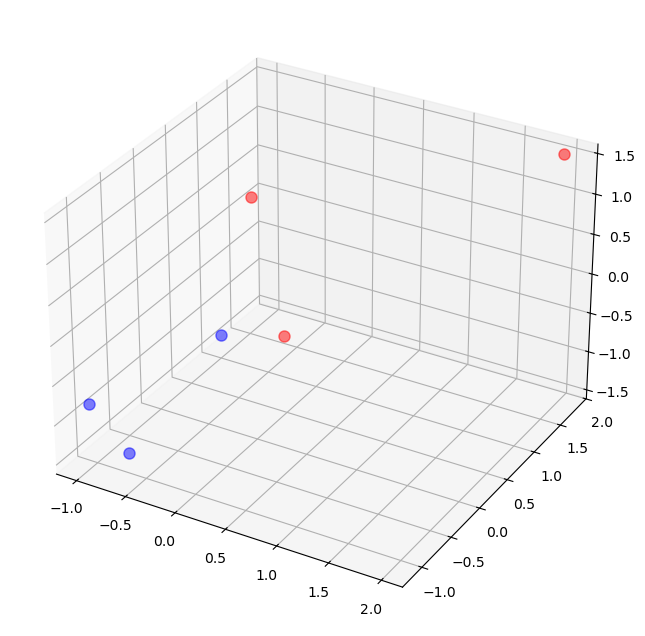

In [23]:



fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10
ax.plot(X_r[0,0:int(num_instances/2)], X_r[1,0:int(num_instances/2)], X_r[2,0:int(num_instances/2)], 'o', markersize=8, color='red', alpha=0.5, label='class1')
ax.plot(X_r[0,int(num_instances/2):num_instances], X_r[1,int(num_instances/2):num_instances], X_r[2,int(num_instances/2):num_instances], 'o', markersize=8, color='blue', alpha=0.5, label='class2')

plt.show()


Volvemos a calcular media y varianza:

In [24]:
mean=np.mean(X_r,axis=1)
std=np.std(X_r,axis=1,ddof=1)
var=np.var(X_r,axis=1,ddof=1)

print ("Medias:",mean)
print ("Varianzas:",var)
print ("Desviaciones estándar:",std)

Medias: [ 0. -0. -0.]
Varianzas: [1.2 1.2 1.2]
Desviaciones estándar: [1.095 1.095 1.095]


La covarianza se define como:

$$ cov(X, Y) = = \frac{\sum_{i=n}^n (X_i - \bar{X})(Y_i - \bar{Y}) }{n-1} $$


y es una medida estadística que mide cómo se relacionan dos dimensiones. Si la covarianza es positiva, indica que ambas dimensiones crecen juntas, mientras que si es negativa, indica que cuando una crece, la otra decrece. Si la covarianza es 0, entonces las dimensiones son independientes (es decir, modificar una no afecta a la otra).

La matriz de covarianza tiene en cada elemento de la diagonal la varianza de la dimensión correspondiente, y en su elemento $ c_{ij}$ la covarianza de las dimensiones $i$ y $j$ (nótese que $cov(i,j)=cov(j,i)$ y por lo tanto la matriz es simétrica).

In [25]:
cvm=np.cov(X_r)
print (cvm)

[[1.2   0.968 0.935]
 [0.968 1.2   1.102]
 [0.935 1.102 1.2  ]]


Como la matriz es simétrica, sabemos que su valores propios son reales, así que vamos a calcularlos, y de esta forma obtendremos las direcciones en las que hay mayor varianza. Utilizamos para eso la función eig de Numpy.

In [26]:
eig_val_cov, eig_vec_cov = np.linalg.eig(cvm)

for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T

    print('Valor propio {} de la matriz de covarianza {:.2f}'.format(i+1, eig_val_cov[i]))
    print('Vector propio: {}'.format(eigvec_cov.flatten()))


Valor propio 1 de la matriz de covarianza 3.21
Vector propio: [0.557 0.59  0.584]
Valor propio 2 de la matriz de covarianza 0.30
Vector propio: [ 0.826 -0.326 -0.459]
Valor propio 3 de la matriz de covarianza 0.10
Vector propio: [ 0.08  -0.739  0.669]


Los vectores propios obtenidos nos indican las direcciones en las que los datos varían más. El vector con el mayor valor propio (en términos absolutos) es el _componente principal_ de la matriz, es decir que muestra la dirección en la que los datos están más dispersos. Y así podemos continuar, viendo las dimensiones donde hay más variación, ordenando los vectores propios según sus valores propios.

In [27]:
# Hacemos una lista de tuplas (valor propio, vector propio) y las ordenamos de mayor a meno
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
eig_pairs.sort()
eig_pairs.reverse()


for i in eig_pairs:
    print ("Valor propio {}, Vector propio {}".format(i[0],i[1]))



Valor propio 3.2055337366682974, Vector propio [0.557 0.59  0.584]
Valor propio 0.29880117000138967, Vector propio [ 0.826 -0.326 -0.459]
Valor propio 0.09566509333031288, Vector propio [ 0.08  -0.739  0.669]


Ahora reduciremos la dimensión de nuestro conjunto original para dejarlo en 2 dimensiones. En lugar de seleccionar dos atributos, haremos antes un cambio de base para expresar cada punto como una combinación lineal de los dos componentes principales (es decir, los dos vectores propios con mayores valores propios).

Para esto, construimos una matrix $W \in \mathbb{R}^{3 \times 2}$ que tiene en sus columnas los vectores propios:

In [28]:
# Creamos una columna por vector propio, hasta el número de dimensiones que querramos (en nuestro caso, dos)
W = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))

# Por si queremos probar con las tres dimensiones originales
# W = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1), eig_pairs[2][1].reshape(3,1)))

print('Matriz W:\n', W)



Matriz W:
 [[ 0.557  0.826]
 [ 0.59  -0.326]
 [ 0.584 -0.459]]


Transformar las instancias al nuevo subespacio es  multiplicar _por la izquierda_ nuestra matriz $X_r \in \mathbb{R}^{3 \times m}$  por $W^T \in \mathbb{R}^{2 \times 3}$ ($W^TX_r$). El resultado tendrá (verificar!) dos filas y $m$ columnas.

In [29]:
# Transformamos la instancia al nuevo subespacio
DatosFinales=W.transpose()@X_r
print (DatosFinales)

[[ 3.069  0.101  0.627 -1.66  -0.306 -1.832]
 [ 0.341  0.401 -1.049 -0.101  0.099  0.31 ]]


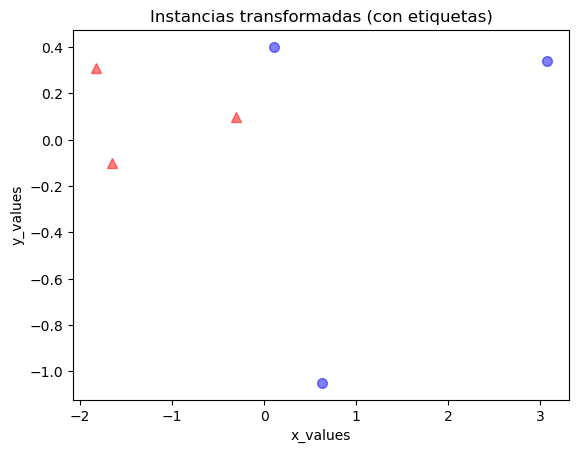

In [30]:
plt.plot(DatosFinales[0,0:int(num_instances/2)], DatosFinales[1,0:int(num_instances/2)], 'o', markersize=7, color='blue', alpha=0.5, label='men')
plt.plot(DatosFinales[0,int(num_instances/2):num_instances], DatosFinales[1,int(num_instances/2):num_instances], '^', markersize=7, color='red', alpha=0.5, label='women')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
#plt.legend()
plt.title('Instancias transformadas (con etiquetas)')

plt.show()



Hemos obtenido un nuevo dataset con una dimensión menos, pero que respeta (tanto como es posible) la dispersión de los datos, porque tiene las dos dimensiones de mayor varianza.

Al ver los valores propios, observamos que uno de ellos era mucho mayor que los otros, así que puede tener sentido ver qué sucede si quitamos una dimensión más:

In [31]:
# Solo una dimensión
W2 = np.hstack((eig_pairs[0][1].reshape(3,1),))
print('Matriz W2:\n', W2)

Matriz W2:
 [[0.557]
 [0.59 ]
 [0.584]]


In [32]:
DatosFinales2=W2.transpose()@X_r
print (DatosFinales2)

[[ 3.069  0.101  0.627 -1.66  -0.306 -1.832]]


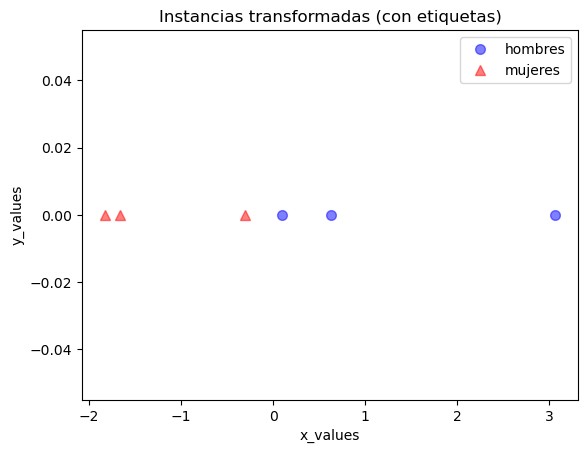

In [33]:
plt.plot(DatosFinales2[0,0:int(num_instances/2)],np.zeros(int(num_instances/2)), 'o', markersize=7, color='blue', alpha=0.5, label='hombres')
plt.plot(DatosFinales2[0,int(num_instances/2):num_instances],np.zeros(int(num_instances/2)), '^', markersize=7, color='red', alpha=0.5, label='mujeres')
#plt.xlim([-4,4])
#plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Instancias transformadas (con etiquetas)')

plt.show()

Si quisiéramos obtener los datos originales, simplemente deberíamos revertir el proceso . Es decir, dado que:

$$ DatosFinales = W^T \times X_r$$

entonces

$$X_r = (W^T)^{-1} \times  DatosFinales$$

(Esto solamente podemos hacerlo si conservamos las dimensiones originales, porque de lo contrario W no será cuadrada).

Pero, como W es la matriz de los vectores propios, y por lo tanto es ortogonal, su inversa será igual a su traspuesta y tendremos:

$$X_r = (W^T)^{T} \times DatosFinales = W \times DatosFinales $$

y, por lo tanto

$$X  = (W \times DatosFinales) \times DesviacionEstandar + MediaOrigen $$



Si aplicamos la fórmula anterior luego de haber reducido las dimensiones, funcionará, pero nuestro "dataset original" habrá perdido información por el camino:



In [34]:
print (W@DatosFinales * DesviacionEstandar + MediaOrigen)

print(X)

[[  1.971   1.798   1.701   1.648   1.747   1.674]
 [108.078  72.748  88.383  55.279  69.927  50.584]
 [  5.011   4.784   4.909   4.681   4.771   4.643]]
[[  1.97   1.8    1.7    1.65   1.75   1.67]
 [110.    70.    90.    52.    65.    58.  ]
 [  5.     4.8    4.9    4.7    4.8    4.6 ]]
